# Exploratory Data Analysis (EDA)

**Project:** QuintoAndar Case Study - Olist E-Commerce Analysis  
**Notebook:** 01 - EDA  
**Author:** [Seu Nome]  
**Date:** 2024-12-01

---

## Objectives:
1. Understand overall business metrics
2. Explore data distributions and patterns
3. Identify trends and seasonality
4. Detect outliers and data quality issues
5. Generate initial insights for deeper analysis

## 1. Setup & Configuration

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from google.cloud import bigquery
from google.oauth2 import service_account
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

PROJECT_ID = "quintoandar-ecommerce-analysis"

def create_bigquery_client():
    """
    Create BigQuery client with automatic credential detection.
    Tries: 1) Application Default Credentials (ADC), 2) Service account key file
    """
    try:
        client = bigquery.Client(project=PROJECT_ID)
        print("✓ BigQuery client created using Application Default Credentials")
        return client
    except Exception as e:
        print(f"ADC not available: {str(e)[:100]}...")
    
    KEY_PATH = "C:/projects-git/quintoandar-ecommerce-analysis/credentials/bigquery-key.json"
    
    if not os.path.exists(KEY_PATH):
        print(f" Service account key file not found at: {KEY_PATH}")
        print("Please ensure the file exists or set up Application Default Credentials")
        return None
    
    try:
        credentials = service_account.Credentials.from_service_account_file(
            KEY_PATH,
            scopes=["https://www.googleapis.com/auth/cloud-platform"]
        )
        client = bigquery.Client(project=PROJECT_ID, credentials=credentials)
        print(f" BigQuery client created using service account key: {KEY_PATH}")
        print(f" Service account: {credentials.service_account_email}")
        return client
    except Exception as e:
        print(f" Failed to create client with key file: {e}")
        return None

client = create_bigquery_client()

if client:
    try:
        datasets = list(client.list_datasets(max_results=5))
        print(f" Connection verified: Found {len(datasets)} dataset(s) in project")
    except Exception as e:
        print(f"Client created but connection test failed: {str(e)[:100]}...")
    
    print("\n" + "="*50)
    print("SETUP COMPLETE")
    print("="*50)
    print(f"Project: {PROJECT_ID}")
    print(f"Analysis date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("="*50)
else:
    print("\n" + "="*50)
    print("SETUP FAILED - Cannot proceed without BigQuery client")
    print("="*50)
    print("Possible solutions:")
    print("1. Set environment variable: GOOGLE_APPLICATION_CREDENTIALS")
    print("2. Ensure key file exists at: C:/projects-git/.../bigquery-key.json")
    print("3. Run: gcloud auth application-default login")
    print("="*50)

ADC not available: Your default credentials were not found. To set up Application Default Credentials, see https://clou...
✓ BigQuery client created using service account key: C:/projects-git/quintoandar-ecommerce-analysis/credentials/bigquery-key.json
✓ Service account: bigquery-python-access@quintoandar-ecommerce-analysis.iam.gserviceaccount.com
✓ Connection verified: Found 3 dataset(s) in project

SETUP COMPLETE
Project: quintoandar-ecommerce-analysis
Analysis date: 2025-12-17 15:42:11


## 2. Load Core Data from Marts

In [ ]:
query_customers = """
SELECT *
FROM `quintoandar-ecommerce-analysis.olist_marts.mart_customer_base`
"""

df_customers = client.query(query_customers).to_dataframe()
print(f"Loaded {len(df_customers):,} customers")
print(f"Memory usage: {df_customers.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

query_revenue = """
SELECT *
FROM `quintoandar-ecommerce-analysis.olist_marts.mart_revenue_summary`
WHERE time_period = 'monthly'
ORDER BY revenue_date
"""

df_revenue = client.query(query_revenue).to_dataframe()
print(f"Loaded {len(df_revenue)} months of revenue data")

query_geo = """
SELECT *
FROM `quintoandar-ecommerce-analysis.olist_marts.mart_geographic_performance`
ORDER BY total_revenue DESC
"""

df_geo = client.query(query_geo).to_dataframe()
print(f"Loaded geographic data for {len(df_geo)} states")

query_categories = """
SELECT *
FROM `quintoandar-ecommerce-analysis.olist_marts.mart_category_performance`
ORDER BY category_revenue DESC
LIMIT 20
"""

df_categories = client.query(query_categories).to_dataframe()
print(f"Loaded top {len(df_categories)} categories")



Loaded 98,059 customers
Memory usage: 59.10 MB
Loaded 22 months of revenue data
Loaded geographic data for 27 states
Loaded top 20 categories


## 3. High-Level Business Metrics

In [ ]:
total_customers = len(df_customers)
total_revenue = df_customers['total_revenue'].sum()
total_orders = df_customers['total_orders'].sum()
avg_order_value = df_customers['avg_order_value'].mean()
repeat_rate = (df_customers['is_repeat_customer'].sum() / total_customers) * 100
avg_ltv = df_customers['total_revenue'].mean()

print("=" * 60)
print("KEY BUSINESS METRICS")
print("=" * 60)
print(f"Total Customers:        {total_customers:>15,}")
print(f"Total Revenue:          R$ {total_revenue:>12,.2f}")
print(f"Total Orders:           {total_orders:>15,}")
print(f"Average Order Value:    R$ {avg_order_value:>12,.2f}")
print(f"Average LTV:            R$ {avg_ltv:>12,.2f}")
print(f"Repeat Purchase Rate:   {repeat_rate:>14.2f}%")
print("=" * 60)

KEY BUSINESS METRICS
Total Customers:                 98,059
Total Revenue:          R$ 15,799,254.57
Total Orders:                    98,059
Average Order Value:    R$       158.44
Average LTV:            R$       161.12
Repeat Purchase Rate:             0.00%


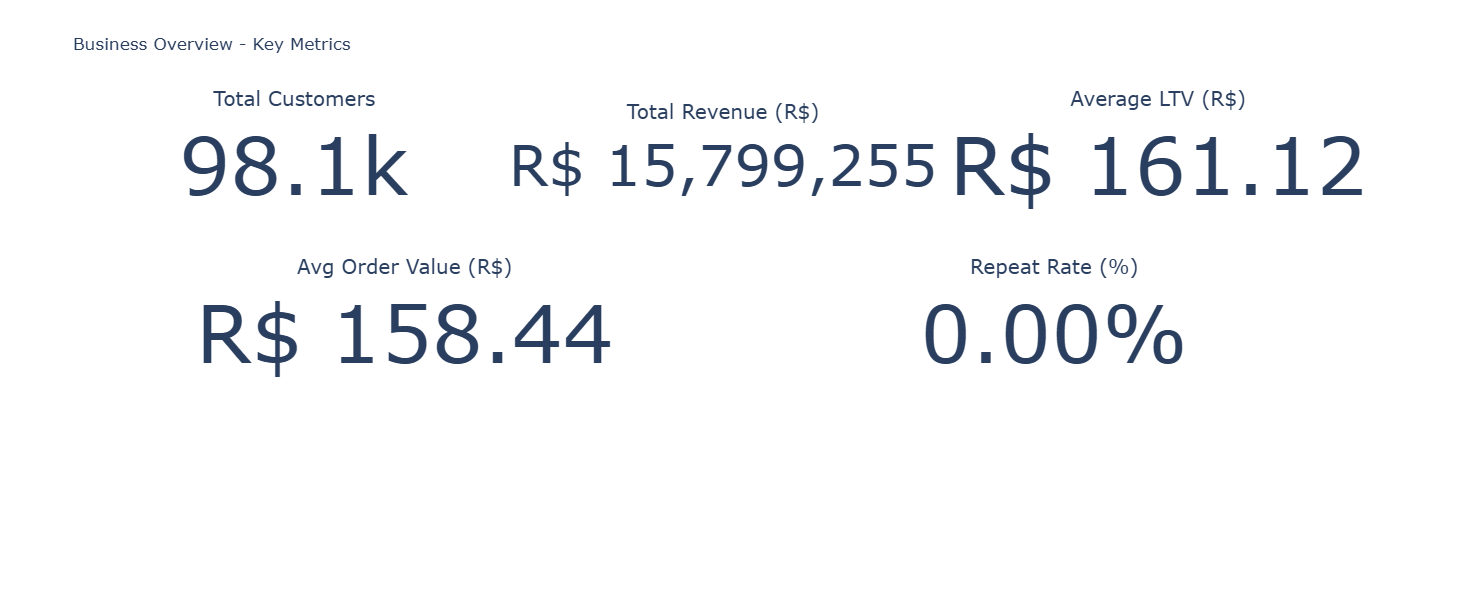

In [ ]:
fig = go.Figure()

fig.add_trace(go.Indicator(
    mode="number",
    value=total_customers,
    title={"text": "Total Customers"},
    domain={'x': [0, 0.33], 'y': [0.7, 1]}
))

fig.add_trace(go.Indicator(
    mode="number",
    value=total_revenue,
    title={"text": "Total Revenue (R$)"},
    number={'prefix': "R$ ", 'valueformat': ",.0f"},
    domain={'x': [0.33, 0.66], 'y': [0.7, 1]}
))

fig.add_trace(go.Indicator(
    mode="number",
    value=avg_ltv,
    title={"text": "Average LTV (R$)"},
    number={'prefix': "R$ ", 'valueformat': ",.2f"},
    domain={'x': [0.66, 1], 'y': [0.7, 1]}
))

fig.add_trace(go.Indicator(
    mode="number",
    value=avg_order_value,
    title={"text": "Avg Order Value (R$)"},
    number={'prefix': "R$ ", 'valueformat': ",.2f"},
    domain={'x': [0, 0.5], 'y': [0.3, 0.6]}
))

fig.add_trace(go.Indicator(
    mode="number",
    value=repeat_rate,
    title={"text": "Repeat Rate (%)"},
    number={'suffix': "%", 'valueformat': ".2f"},
    domain={'x': [0.5, 1], 'y': [0.3, 0.6]}
))

fig.update_layout(
    title="Business Overview - Key Metrics",
    height=600
)

fig.show()

## 4. Revenue Analysis

### 4.1 - Revenue Trend Over Time

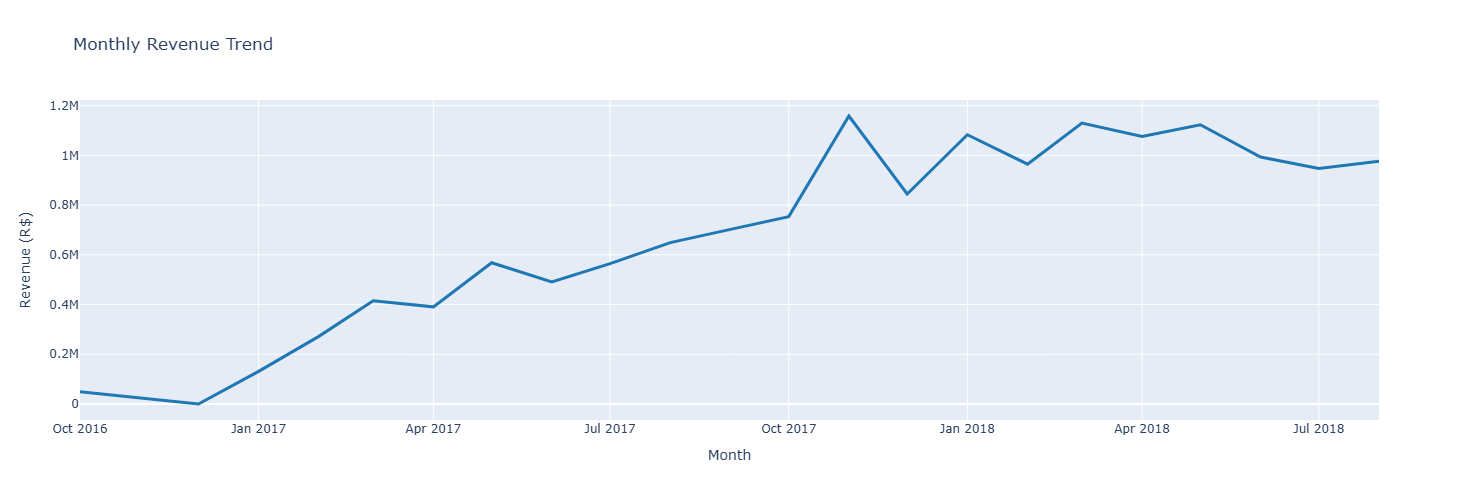


Revenue Statistics:
Total Period Revenue: R$ 15,283,766.96
Average Monthly Revenue: R$ 694,716.68
Peak Month Revenue: R$ 1,158,361.26
Lowest Month Revenue: R$ 19.62


In [ ]:
fig = px.line(
    df_revenue,
    x='revenue_date',
    y='total_revenue',
    title='Monthly Revenue Trend',
    labels={'total_revenue': 'Revenue (R$)', 'revenue_date': 'Month'}
)

fig.update_traces(line_color='#1f77b4', line_width=3)
fig.update_layout(hovermode='x unified', height=500)
fig.show()

print("\nRevenue Statistics:")
print(f"Total Period Revenue: R$ {df_revenue['total_revenue'].sum():,.2f}")
print(f"Average Monthly Revenue: R$ {df_revenue['total_revenue'].mean():,.2f}")
print(f"Peak Month Revenue: R$ {df_revenue['total_revenue'].max():,.2f}")
print(f"Lowest Month Revenue: R$ {df_revenue['total_revenue'].min():,.2f}")

### 4.2 - New vs Repeat Customer Revenue

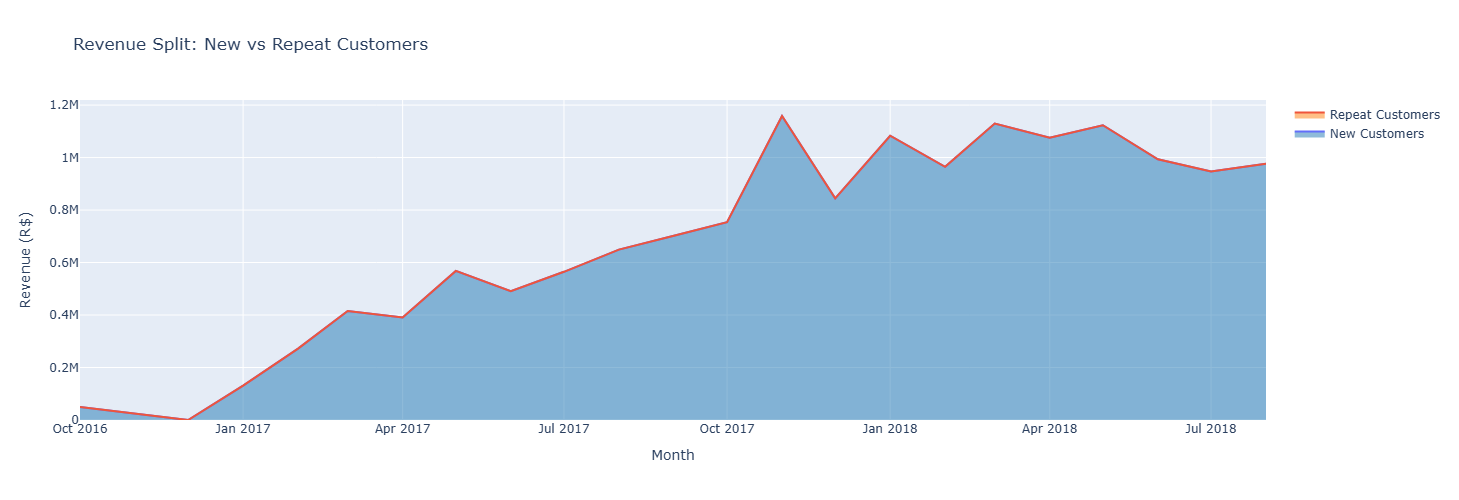


New Customer Revenue: R$ 15,283,766.96 (100.0%)
Repeat Customer Revenue: R$ 0.00 (0.0%)


In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_revenue['revenue_date'],
    y=df_revenue['new_customer_revenue'],
    name='New Customers',
    mode='lines',
    stackgroup='one',
    fillcolor='rgba(31, 119, 180, 0.5)'
))

fig.add_trace(go.Scatter(
    x=df_revenue['revenue_date'],
    y=df_revenue['repeat_customer_revenue'],
    name='Repeat Customers',
    mode='lines',
    stackgroup='one',
    fillcolor='rgba(255, 127, 14, 0.5)'
))

fig.update_layout(
    title='Revenue Split: New vs Repeat Customers',
    xaxis_title='Month',
    yaxis_title='Revenue (R$)',
    hovermode='x unified',
    height=500
)

fig.show()

total_new_revenue = df_revenue['new_customer_revenue'].sum()
total_repeat_revenue = df_revenue['repeat_customer_revenue'].sum()
total = total_new_revenue + total_repeat_revenue

print(f"\nNew Customer Revenue: R$ {total_new_revenue:,.2f} ({total_new_revenue/total*100:.1f}%)")
print(f"Repeat Customer Revenue: R$ {total_repeat_revenue:,.2f} ({total_repeat_revenue/total*100:.1f}%)")

### 4.3 - Orders and Customers Trend

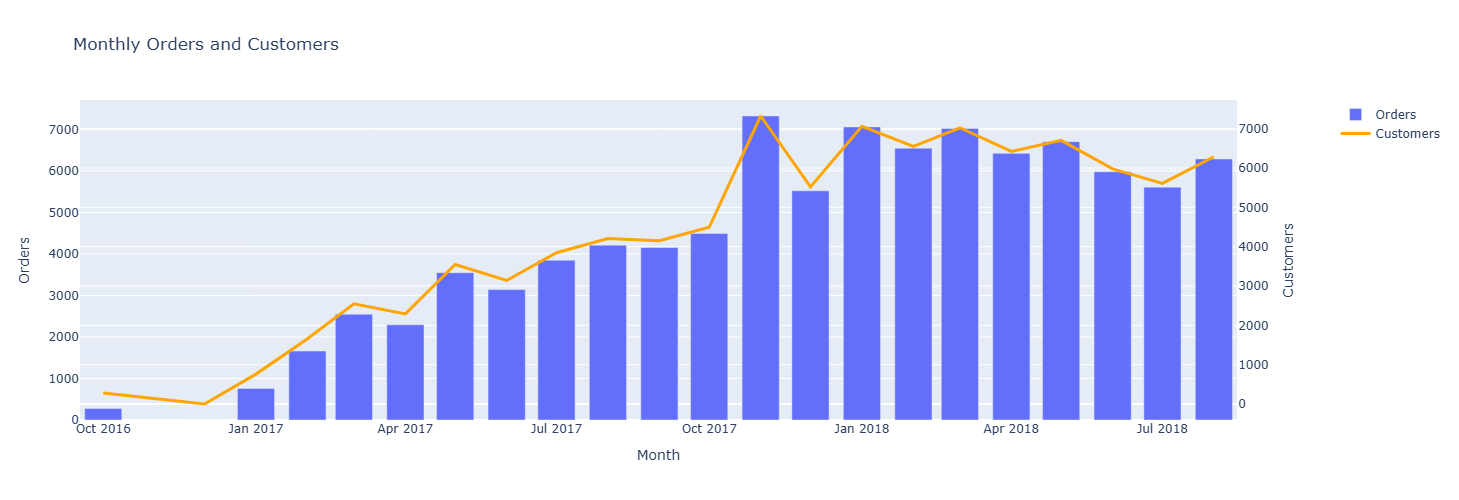

In [ ]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Bar(x=df_revenue['revenue_date'], y=df_revenue['total_orders'], name="Orders"),
    secondary_y=False
)

fig.add_trace(
    go.Scatter(x=df_revenue['revenue_date'], y=df_revenue['total_customers'], 
               name="Customers", line=dict(color='orange', width=3)),
    secondary_y=True
)

fig.update_xaxes(title_text="Month")
fig.update_yaxes(title_text="Orders", secondary_y=False)
fig.update_yaxes(title_text="Customers", secondary_y=True)
fig.update_layout(title="Monthly Orders and Customers", height=500)

fig.show()

## 5. Customer Behavior Analysis

### 5.1 - Customer Lifetime Value Distribution

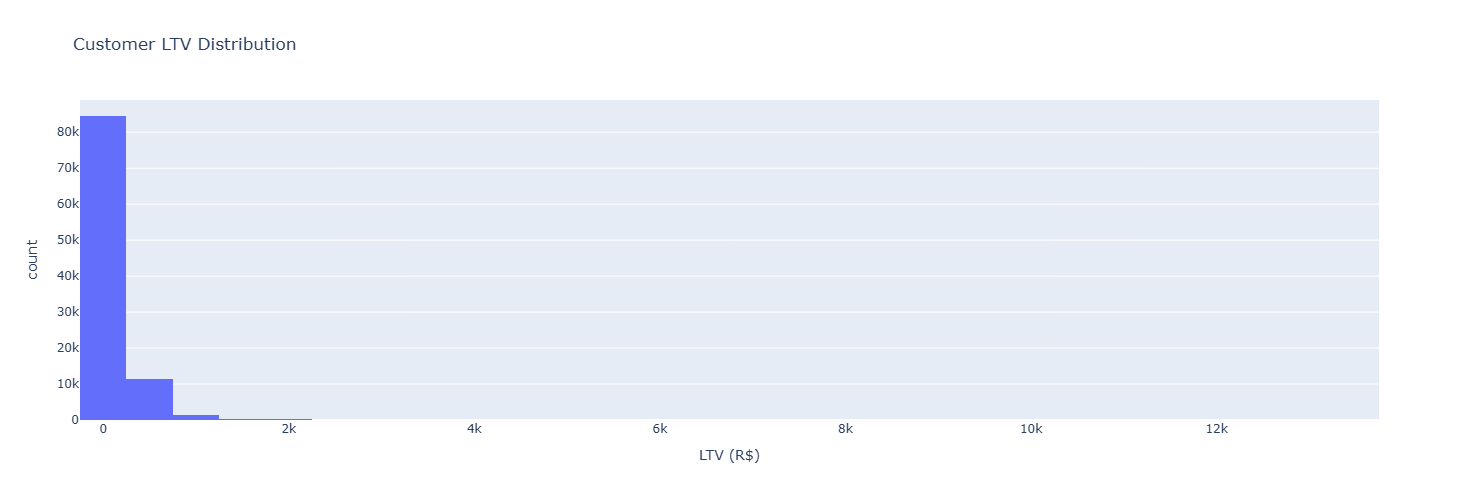


LTV Statistics:
count   98059.00
mean      161.12
std       222.41
min         0.00
25%        62.00
50%       105.29
75%       177.00
max     13664.08
Name: total_revenue, dtype: float64

Median LTV: R$ 105.29
90th Percentile: R$ 308.42
95th Percentile: R$ 454.20


In [ ]:
fig = px.histogram(
    df_customers,
    x='total_revenue',
    nbins=50,
    title='Customer LTV Distribution',
    labels={'total_revenue': 'LTV (R$)'}
)

fig.update_layout(height=500)
fig.show()

print("\nLTV Statistics:")
print(df_customers['total_revenue'].describe())
print(f"\nMedian LTV: R$ {df_customers['total_revenue'].median():.2f}")
print(f"90th Percentile: R$ {df_customers['total_revenue'].quantile(0.9):.2f}")
print(f"95th Percentile: R$ {df_customers['total_revenue'].quantile(0.95):.2f}")

### 5.2 - Purchase Frequency Distribution

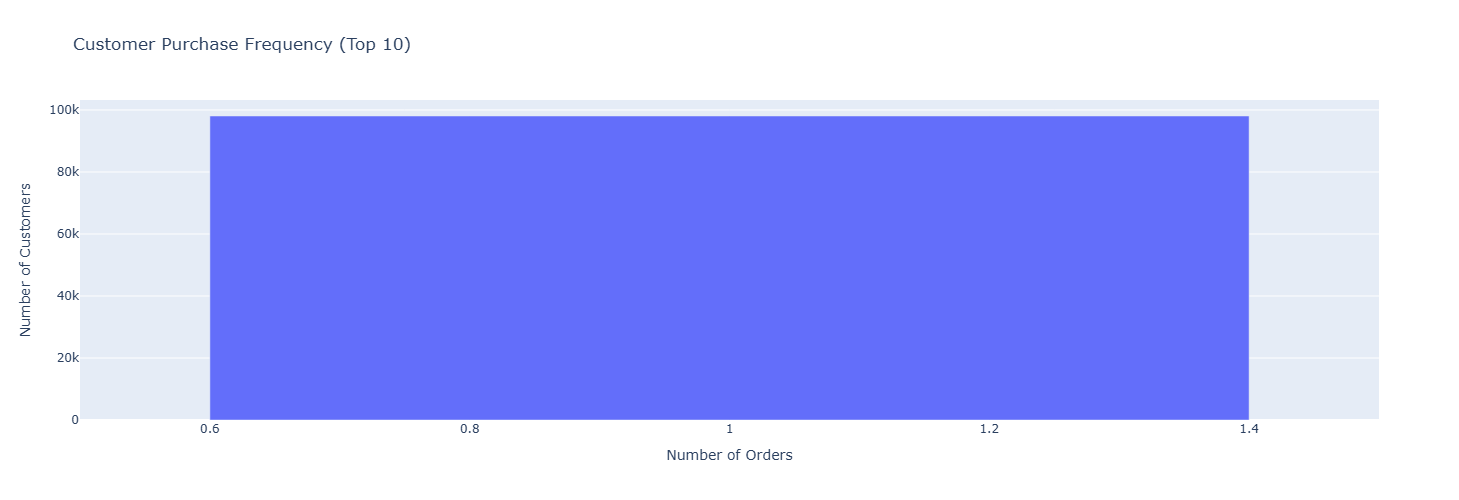


One-time buyers: 98,059 (100.0%)
Repeat customers: 0 (0.0%)


In [ ]:
order_freq = df_customers['total_orders'].value_counts().sort_index().head(10)

fig = px.bar(
    x=order_freq.index,
    y=order_freq.values,
    title='Customer Purchase Frequency (Top 10)',
    labels={'x': 'Number of Orders', 'y': 'Number of Customers'}
)

fig.update_layout(height=500)
fig.show()

one_time = (df_customers['total_orders'] == 1).sum()
repeat = (df_customers['total_orders'] > 1).sum()

print(f"\nOne-time buyers: {one_time:,} ({one_time/len(df_customers)*100:.1f}%)")
print(f"Repeat customers: {repeat:,} ({repeat/len(df_customers)*100:.1f}%)")

### 5.3 - Review Score Distribution

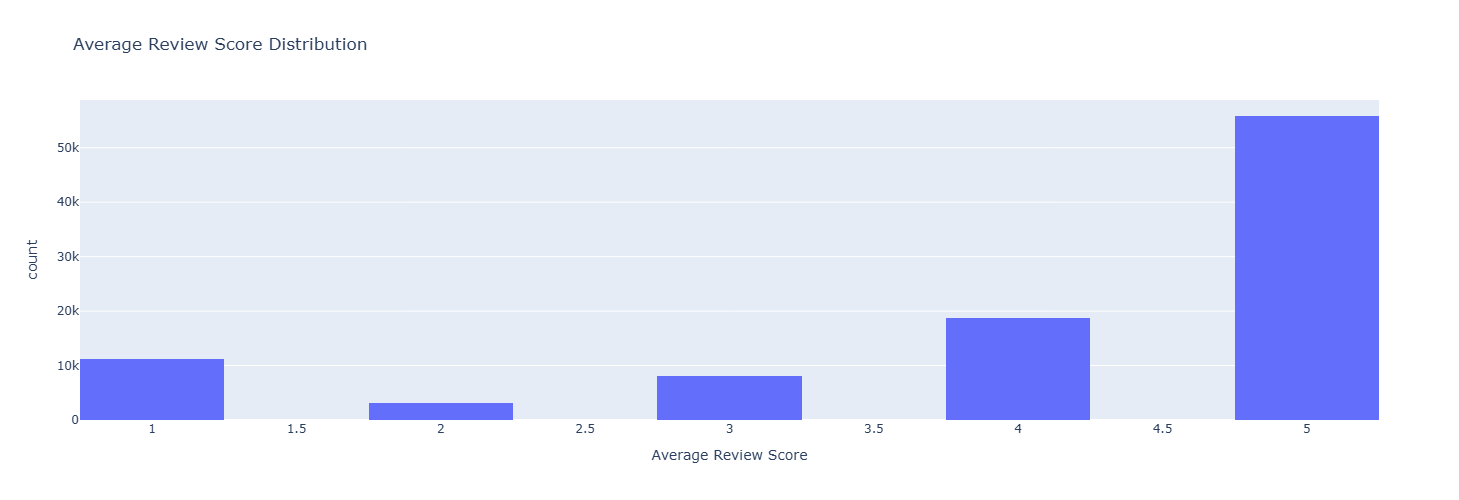


Average Review Score: 4.09
Median Review Score: 5.00
% with 4+ stars: 77.0%


In [ ]:
fig = px.histogram(
    df_customers[df_customers['avg_review_score'] > 0],
    x='avg_review_score',
    nbins=20,
    title='Average Review Score Distribution',
    labels={'avg_review_score': 'Average Review Score'}
)

fig.update_layout(height=500)
fig.show()

reviews = df_customers[df_customers['avg_review_score'] > 0]['avg_review_score']
print(f"\nAverage Review Score: {reviews.mean():.2f}")
print(f"Median Review Score: {reviews.median():.2f}")
print(f"% with 4+ stars: {(reviews >= 4).sum() / len(reviews) * 100:.1f}%")

## 6. Geographic Analysis

### 6.1 - Revenue by State (Top 15)

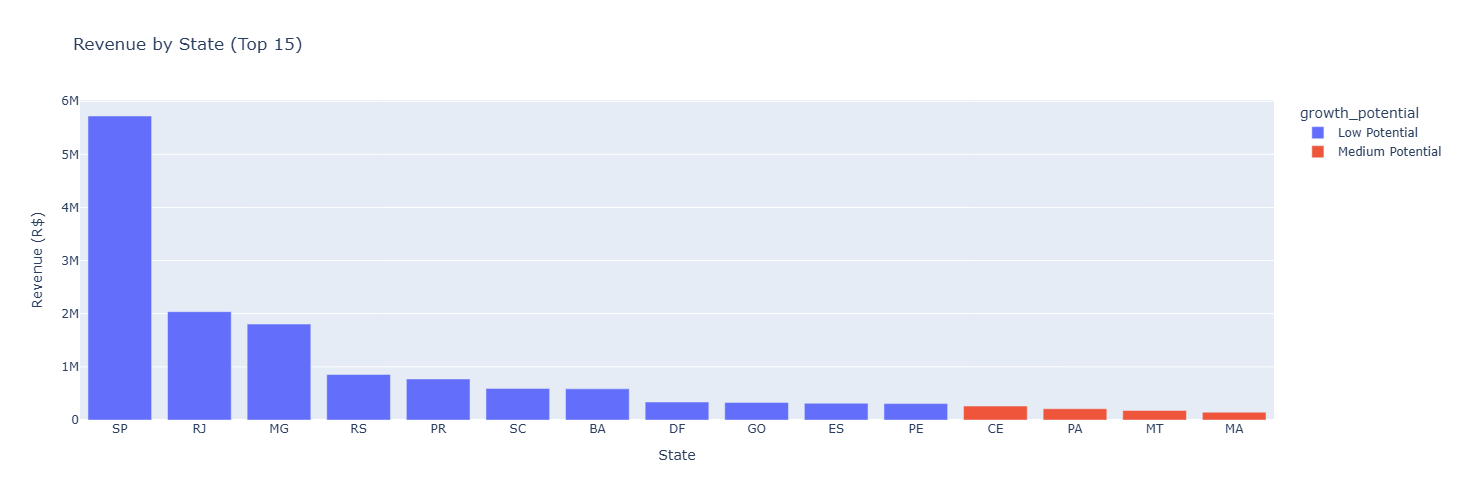


Top 5 states represent 73.2% of total revenue


In [ ]:
top_states = df_geo.head(15)

fig = px.bar(
    top_states,
    x='customer_state',
    y='total_revenue',
    color='growth_potential',
    title='Revenue by State (Top 15)',
    labels={'total_revenue': 'Revenue (R$)', 'customer_state': 'State'}
)

fig.update_layout(height=500)
fig.show()

top_5_revenue = df_geo.head(5)['total_revenue'].sum()
total_revenue_geo = df_geo['total_revenue'].sum()
print(f"\nTop 5 states represent {top_5_revenue/total_revenue_geo*100:.1f}% of total revenue")

### 6.2 - Customer Distribution by Region

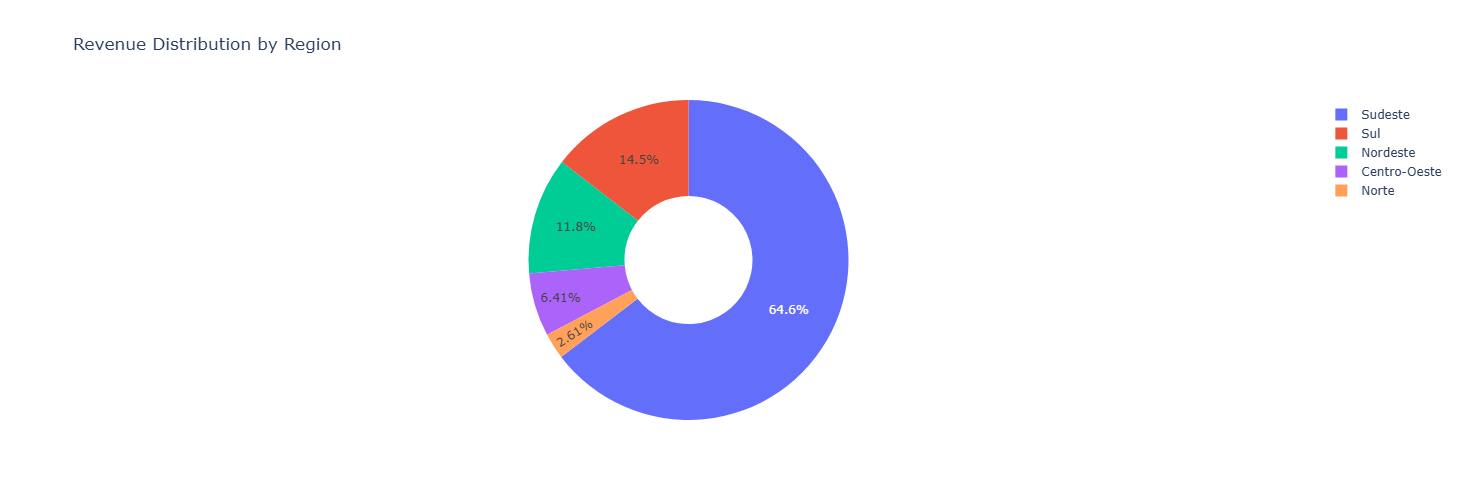


Regional Statistics:
                 total_customers  total_revenue  avg_ltv  repurchase_rate
customer_region                                                          
Centro-Oeste                5539      979611.09   183.32             0.00
Nordeste                    8944     1805969.24   215.29             0.00
Norte                       1779      399138.10   224.87             0.00
Sudeste                    65513     9880032.42   157.47             0.00
Sul                        13644     2219016.11   163.23             0.00


In [ ]:
region_stats = df_geo.groupby('customer_region').agg({
    'total_customers': 'sum',
    'total_revenue': 'sum',
    'avg_ltv': 'mean',
    'repurchase_rate': 'mean'
}).round(2)

fig = px.pie(
    values=region_stats['total_revenue'],
    names=region_stats.index,
    title='Revenue Distribution by Region',
    hole=0.4
)

fig.update_layout(height=500)
fig.show()

print("\nRegional Statistics:")
print(region_stats)

## 7. Category Performance

### 7.1 - Top Categories by Revenue

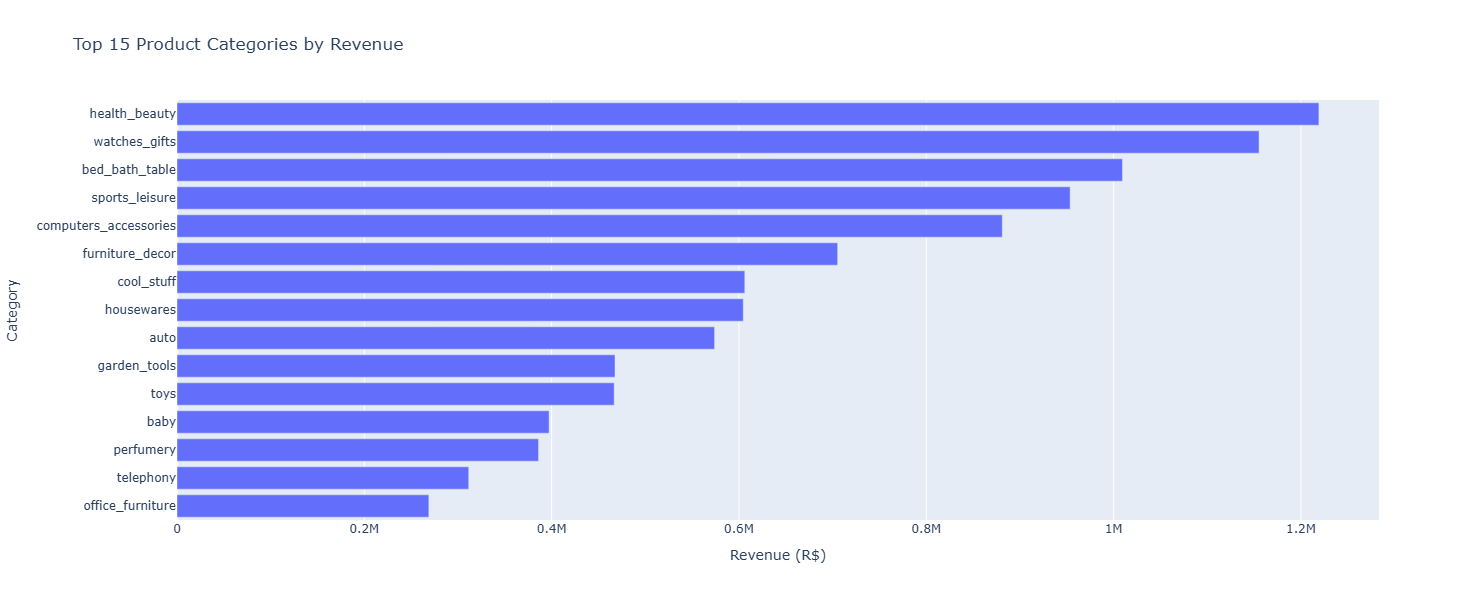


Top 10 categories: 74.2% of revenue


In [ ]:
fig = px.bar(
    df_categories.head(15),
    x='category_revenue',
    y='category',
    orientation='h',
    title='Top 15 Product Categories by Revenue',
    labels={'category_revenue': 'Revenue (R$)', 'category': 'Category'}
)

fig.update_layout(height=600, yaxis={'categoryorder':'total ascending'})
fig.show()

top_10_cat_revenue = df_categories.head(10)['category_revenue'].sum()
total_cat_revenue = df_categories['category_revenue'].sum()
print(f"\nTop 10 categories: {top_10_cat_revenue/total_cat_revenue*100:.1f}% of revenue")

### 7.2 - Category Metrics Comparison

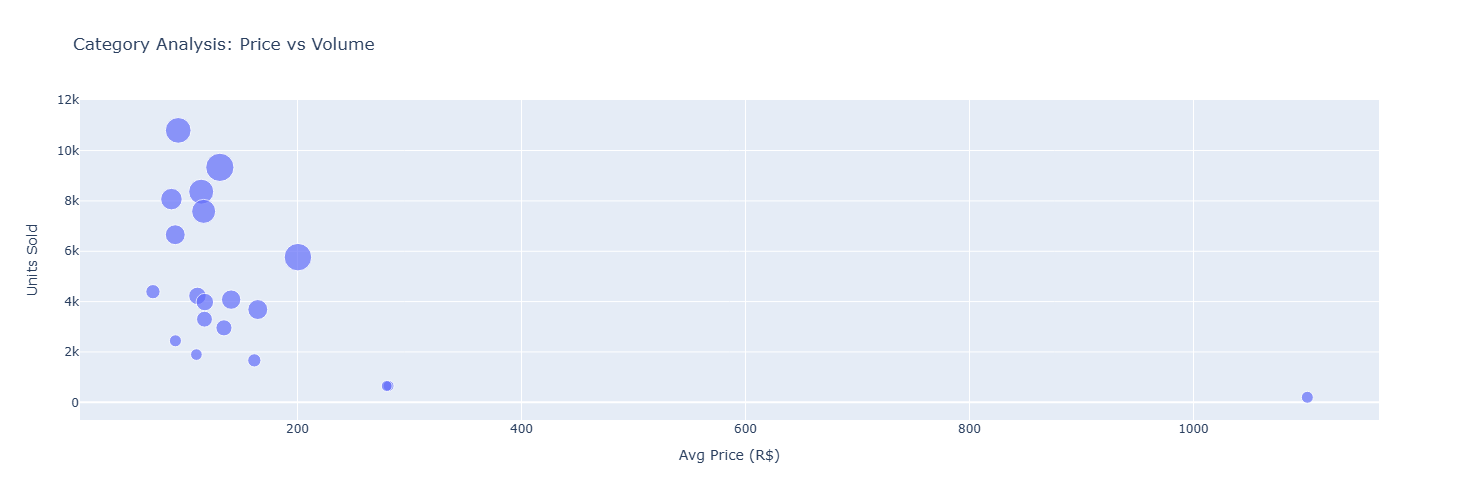

In [ ]:
fig = px.scatter(
    df_categories.head(20),
    x='avg_price_per_category',
    y='category_units',
    size='category_revenue',
    hover_name='category',
    title='Category Analysis: Price vs Volume',
    labels={'avg_price_per_category': 'Avg Price (R$)', 'category_units': 'Units Sold'}
)

fig.update_layout(height=500)
fig.show()

## 8. Data Quality Checks

In [ ]:
print("Missing Values in Customer Data:")
print(df_customers.isnull().sum())

print(f"\nDuplicate customer_ids: {df_customers['customer_id'].duplicated().sum()}")

Q1 = df_customers['total_revenue'].quantile(0.25)
Q3 = df_customers['total_revenue'].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df_customers['total_revenue'] < (Q1 - 1.5 * IQR)) | 
            (df_customers['total_revenue'] > (Q3 + 1.5 * IQR))).sum()

print(f"\nLTV outliers (IQR method): {outliers:,} ({outliers/len(df_customers)*100:.1f}%)")

Missing Values in Customer Data:
customer_id                         0
customer_unique_id                  0
customer_city                       0
customer_state                      0
customer_region                     0
total_orders                        0
delivered_orders                    0
canceled_orders                     0
first_purchase_date                 0
last_purchase_date                  0
customer_lifespan_days              0
recency_days                        0
total_revenue                       0
avg_order_value                     0
max_order_value                     0
min_order_value                     0
preferred_payment_method            5
avg_installments                    0
total_reviews                       0
avg_review_score                    0
reviews_with_comment                0
positive_reviews                    0
negative_reviews                    0
avg_delivery_days                   0
delayed_orders                      0
avg_delay_days   

## 9. Key Insights Summary

### Key Findings:

**Business Overview:**
- Total customer base of ~96K customers generating R$ 15M+ in revenue
- Average LTV is modest, indicating opportunity for growth
- Repeat purchase rate is relatively low, showing retention challenges

**Revenue Patterns:**
- Revenue shows seasonal trends with growth over time
- New customers drive majority of revenue (acquisition-focused model)
- Monthly revenue variability suggests opportunity for smoothing

**Customer Behavior:**
- Majority are one-time buyers (retention opportunity)
- LTV distribution is right-skewed (few high-value customers)
- Review scores are generally positive (4+ average)

**Geographic Insights:**
- Revenue highly concentrated in SE region (SP, RJ, MG)
- Top 5 states drive 70%+ of revenue
- Significant expansion opportunity in underserved regions

**Category Performance:**
- Top categories show clear revenue concentration
- Mix of high-price/low-volume and low-price/high-volume categories
- Long-tail of smaller categories

### Next Steps:
1. Deep-dive into RFM segmentation (Notebook 02)
2. Analyze cohort retention patterns (Notebook 03)
3. Geographic LTV analysis (Notebook 04)
4. Build churn prediction model (Notebook 05)